# Assignment  Practice Text classification with Naive Bayes 

## Notebook made by   (If not filled in correctly: 0 pts for assignment)

__Name(s)__:  Nathan de Bruijn, David Wessels, Tim Frohlich, Thomas Bellucci

__Student id(s)__ : 11030399, 11323272, 11233982, 11257245

__Email(s)__ : nathanldebruijn@gmail.com, davidwessels15@gmail.com , timfrohlich@gmail.com, th.bellucci@gmail.com

__From repo__: https://github.com/thomas097/Zoekmachines-2018-Naive-Bayes

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. **Assignments without the selfies will not be graded and receive 0 points.**

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img src=https://i.imgur.com/5agchtw.jpgm height="300" width="300">

<img src=https://i.imgur.com/kBjXR2Q.jpg height="300" width="300">


        
<h3>Abstract</h3>
<p>We will do text classification on a collection of Dutch parliamentary questions.
    The website <a href="https://zoek.officielebekendmakingen.nl/zoeken/parlementaire_documenten">officielebekendmakingen.nl</a> lets you search in "kamervragen".
    <!--You can donwload
    <a href='http://data.politicalmashup.nl/kamervragen/PoliDocs_Kamervragen.zip'>this zipfile with Kamervragen in XML</a>
    to see some of the  data in XML format. 
    It also contains style sheets to show the XML well in a browser.  
-->
    The <a href='http://maartenmarx.nl/teaching/zoekmachines/LectureNotes/MySQL/'>MYSQL directory</a> contains an <a href='http://maartenmarx.nl/teaching/zoekmachines/LectureNotes/MySQL/KVR14807.xml'>example   Kamervraag XML file</a> and a file `kvr.csv.gz` with 40K kamervragen in a handy csv format.  
  
 We will use this Kamer Vragen CSV to build a multinomial Naive Bayes classifier from scratch to predict which ministry a novel "kamervraag" belongs to. 

### Imports :

In [2]:
# install unidecode on colab 
!pip install -q unidecode

# data structures
from copy import deepcopy
from collections import defaultdict, Counter
import pandas as pd

# for sklearn implementation of question 7
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.metrics import mutual_info_score
from sklearn.naive_bayes import MultinomialNB

# IO
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt

# linguistic processing
import nltk
from nltk import word_tokenize
from unidecode import unidecode
import re

# math
import numpy as np

# makes sure that all resources that are required are downloaded
nltk.download('punkt')
tqdm.pandas()

[nltk_data] Downloading package punkt to /home/thomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Setup: Loading the Kamer Vragen CSV into Pandas DataFrame

In [3]:
def init(n=False):
    names = ['jaar', 'partij','titel','vraag','antwoord','ministerie']
    fname = 'http://maartenmarx.nl/teaching/zoekmachines/LectureNotes/MySQL/KVR.csv.gz'
  
    # optionally: load a subset of the data if loading it in full takes too long
    kvrdf = None
    if n:
        kvrdf = pd.read_csv(fname, compression='gzip', sep='\t', index_col=0, names=names, nrows=n) 
    else:
        kvrdf = pd.read_csv(fname, compression='gzip', sep='\t', index_col=0, names=names) 
    
    # shuffle data to break up odd temporal inconsistencies in the data 
    kvrdf = kvrdf.sample(frac=1)
    
    # replace NaNs with the string 'nan'
    kvrdf.fillna('nan')

    for kolom in names[1:]:
        kvrdf[kolom]= kvrdf[kolom].astype(str)
    return kvrdf


kvrdf = init()
print('\033[1mShape of the KVR DataFrame\033[0m: {} rows by {} columns'.format(kvrdf.shape[0], kvrdf.shape[1]))
kvrdf.head()

Shape of the KVR DataFrame: 40516 rows by 6 columns


,jaar,partij,titel,vraag,antwoord,ministerie
KVR15875.xml,2002,ChristenUnie,Vragen over de problemen van de Belastingdien...,Op welke problemen is de Belastingdienst tot ...,Het doen van elektronische aangifte is dit ja...,Financiën (FIN)
0000036187.xml,1990,Groen Links,,Zijn voorlichtingsfolders met betrekking tot ...,"Neen, behalve in het Nederlands en het Turks,...",nan
V020316980.xml,2003,VVD,"China gaat, ondanks het dringende verzoek van...",Is het u bekend dat de Werelderfgoedcommissie...,www.savetibet.org/news,nan
KVR22531.xml,2005,PvdA,Vragen over de stand van zaken bij de uitvoer...,Bent u bekend met de uitspraak van 16 februar...,,Vreemdelingenzaken en Integratie (VI)
0000107144.xml,1987,CDA,,Kent u het voorstel van de medische faculteit...,Ik heb kennis genomen van berichten volgens w...,nan


---
# Question 1:
### Normalize the values for "ministerie" and choose 10 ministeries to work with.


In [4]:
# creates a list of normalized terms from a document
def clean_combined(doc):
    return [unidecode(w) for w in word_tokenize(doc.lower()) if w.isalpha()] 

# returns a list of unique tokens in a document
def get_set(combined):
    return list(set(combined))
  
# converts the DataFrame to dictionary format
def DataFrame_to_dict(df, ratio=0.8):
    # maintain dictionaries for training and testing data sets
    train_data, test_data = defaultdict(dict), defaultdict(dict)
    
    # loop through the dataframe
    for i, item in enumerate(df.iterrows()):
        index, row = item        
        c = row['ministerie']

        # tokenize and store in training or testing dict
        if i < df.shape[0]*0.8:
            train_data[c][index.strip()] = row['combined']
        else:
            test_data[c][index.strip()] = row['combined']
    return train_data, test_data
  
  
  
# merge columns titel, vraag and antwoord to define a document
df = kvrdf
df["combined"] = df.titel + df.vraag + df.antwoord

# remove data containing NaNs
df = df[["combined","ministerie"]]
df = df[df['ministerie'] != 'nan']

# calculate number of unique ministries before preprocessing
pre = len(df.ministerie.value_counts().index)

# normalization of ministry/class names
df.ministerie = df.ministerie.apply(unidecode).str.lower().str.replace(r'\(.*\)',"").str.strip()

# pick the then most occurring ministries to work with
ten_classes = list(df.ministerie.value_counts().head(10).index)

print("\nNumber of unique ministries before normalization:",pre)
print("Number of unique ministries after normalization:  ",len(df.ministerie.value_counts().index))

# remove irrelevant df rows (that do not have the ministries we use)
df = df[df['ministerie'].isin(ten_classes)]
print('Number of "kamer vragen" remaining after removal:', len(df), '\n')

# normalize and tokenize document text
df.combined = df.combined.progress_apply(clean_combined)
df["word_set"] = df.combined.progress_apply(get_set)
df["combo_string"] = df['word_set'].str.join(' ')

# create training and testing dictionaries with a ratio 0f 80%-20% from df
train_data, test_data = DataFrame_to_dict(df, ratio=0.8)

# print some additional stats
print('\nTraining data contains exactly {} classes'.format(len(train_data)))
print('Test data contains the same {} classes\n'.format(len(test_data)))
print('\033[1mThe ten classes we will use (with training set counts)\033[0m:')
for c, docs in sorted(train_data.items(), key=lambda x: -len(x[1])):
    print('{} (n={})'.format(c, len(docs)))

  0%|          | 18/22251 [00:00<02:04, 177.93it/s]


Number of unique ministries before normalization: 428
Number of unique ministries after normalization:   121
Number of "kamer vragen" remaining after removal: 22251 



100%|██████████| 22251/22251 [00:01<00:00, 17443.48it/s]



Training data contains exactly 10 classes
Test data contains the same 10 classes

The ten classes we will use (with training set counts):
justitie (n=3699)
volksgezondheid, welzijn en sport (n=2902)
buitenlandse zaken (n=2141)
verkeer en waterstaat (n=1712)
sociale zaken en werkgelegenheid (n=1487)
onderwijs, cultuur en wetenschappen (n=1402)
volkshuisvesting, ruimtelijke ordening en milieubeheer (n=1283)
financien (n=1146)
economische zaken (n=1041)
binnenlandse zaken en koninkrijksrelaties (n=987)


**Defining what constitutes the document and the class:**<br>
The CSV file has been loaded into a pandas ``DataFrame``.  Each row of the DataFrame consists of a single document/"kamervraag". The last item of each row/document contains the "ministerie" which acts as our class label (used for training the Naive Bayes classifier). The document that we would like to classify consists of a concatenation of the "vraag", "antwoord" and "titel" entries of a row. The "jaar" and "partij" entries are discarded.

**Normalizing the content in the DataFrame:**<br>
To be able to use the documents for our Naive Bayes classifier it is necessary to normalize the raw tokens of the text and labels such that different surface forms of the same term get mapped to the same equivalence class. Also, the string of text has to be tokenized (using NLTK's ``word_tokenize``) such that we can determine the multinomial distributions for the classifier. The following normalization steps have been performed on the <i>kamervragen</i> DataFrame as loaded in the ``Setup`` section:

* We solve the problem of having different cases in the data by mapping every token to lowercase (e.g. "Justitie" to "justitie"). This is done for both the "ministeries" column (i.e. the classes) and the text data that represents our document.  
* We apply ``unidecode`` to map all non-ascii characters to their closest counterpart in ascii. This has the result of removing accents and diacritics (e.g. "financiën" to "financien"). This is done for both the "ministeries" column (i.e. the classes) and the text data that represents our document. 
* Abbreviations are removed using regular expressions (e.g. "justitie (JUS)" to "justitie"). This is done for the classes only, because abbreviations (or anything between parentheses) can be a useful feature for the classification process.
* Finally, all tokens containing non-alphanumeric characters are removed. (Note that our tokenization process takes care of non-alphanumeric characters that are stuck to the end of tokens, such as "Nederland.". This string gets tokenized into ["nederland", "."].)

Additionally, care is taken to remove rows/documents containing NaNs.

**Converting from DataFrame to defaultdict:**<br>
Although often very useful, the ``DataFrame`` is not ideal in all cases, for example, when we need to do some processing later on in the assignment. Therefore, the DataFrame is (additionally) converted to a nested Python ``defaultdict`` of the following structure:
```
{
    class_name1 : {
                   doc_name1 : [t1, t2, t3, t4, ...],
                   doc_name2 : [t1, t2, t3, t4, ...],
                   doc_name3 : [t1, t2, t3, t4, ...],
                   ...
                  },
                  
    class_name2 : {
                   doc_name4 : [t1, t2, t3, t4, ...],
                   doc_name5 : [t1, t2, t3, t4, ...],
                   doc_name6 : [t1, t2, t3, t4, ...],
                   ...
                  },
    ...
}
```
This allows us to efficiently create the multinomial distributions required for Naive Bayes. During dictionary construction, it is possible to split the dataset into a training and a test set. This is done now (before any training) to ensure that we do not train on the testing set accidentally. For our final evaluation, we use a 80%-20% split of the full dataset (excluding rows with NaNs) for the training and testing sets respectively. Before splitting, the rows are shuffled/randomized in the DataFrame to ensure that odd temporal variations are accounted for (for example when a  ministry gets another name from one year onwards).

The dictionary representation of the training data is used in the next question to construct the classifier.

---
# Question 2:
### Implement the two algorithms in Fig MRS.13.2, **using your earlier code for creating term and document frequencies**. It might be easier to use the representation and formula given in MRS section 13.4.1.

In [5]:
def extract_vocabulary(data):
    vocab = set()
    for c, docs in data.items():
        for text in docs.values():
            vocab.update(text)
    return set(vocab)


def train_multinomial(data):
    # maintain dict of prior and conditional probabilities
    priors = dict()
    conditionals = defaultdict(lambda: defaultdict(int))
    # determine the vocabulary of terms
    vocab = extract_vocabulary(data)
    # calculate N (the number of documents in our training set)
    n_total = sum([len(doc) for doc in data.values()])
    for c, docs in data.items():
        # calculate prior probability for class
        priors[c] = len(docs)/n_total
        # determine the term frequency of all terms in the documents belonging to class c
        tf = Counter([t for tokens in docs.values() for t in tokens])
        N = sum(tf.values())
        # augment conditional dict with new smoothed probability values     
        for term in vocab:
            conditionals[term][c] = (tf[term]+1)/(N + len(vocab))
    return vocab, priors, conditionals
    

def apply_multinomial(vocab, priors, conditionals, doc):
    doc = [t for t in doc if t in vocab]
    scores = []
    # loop through classes and calculate the log probability of P(c|d)
    for c in priors.keys():
        conditional = 0
        for t in doc:
            conditional += np.log(conditionals[t][c])
        scores.append((np.log(priors[c]) + conditional, c))
    # return c_map
    return max(scores)[1]

The implementation in the code cell above is conceptually similar to the pseudo-code in MRS figure 13.2.

**Vocabulary construction:**<br>
Before creating the multinomial distributions for our classes/ministries, we need to fix our vocabulary. To this end we loop through each document in the training set and store the occurring tokens (or terms because they are already normalized) in a Python set.

**Training the Naive Bayes classifier:**<br>
The parameter estimation / classifier training stage of ``train_multinomial`` consists of two stages:<br>
1) Estimating the prior probabilities of the classes by estimating $P(c) = \frac{N_c}{N}$, where $N_c$ is the length of the set of documents belonging to class $c$.<br>
2) Estimating the conditional probabilities of the term in a class using $P(t|c) = \frac{tf_{t, d_c}}{|d_c|}$, where $d_c$ is the merged document consisting of all documents in class $c$. The function maintains a nested defaultdict which allows us to determine and access the conditional probability of a term with respect to the class in an efficient manner.<br>
Additionally, we smooth the conditional probability using add-one (Laplace) smoothing to minimize the estimation problem and zero-probability problem when using terms from the vocabulary that do not occur in the class (the reason why we pre-compute the vocabulary).

**Applying the classifier:**<br>
To apply our classifier we have implemented the <i>Maximum A Posteriori method</i> $c_{map} = argmax_{c\in C} P(c|d) = argmax_{c\in C} P(c)\prod_{t\in d}P(t|c)$, where $d$ is the document we wish to classify and $C$ the set of all classes. The function maintains the calculated quantity of $P(c|d)$ for each class and returns the class name with the maximum conditional probability of $P(c|d)$. To prevent arithmetic underflow, we apply a log transformation to our probabilities and sum them instead; $c_{map} = argmax_{c\in C} \log(P(c))\sum_{t\in d}\log(P(t|c))$<br>
Care is taken to ensure that all terms/features that are used are in fact in the vocabulary (out-of-vocabulary tokens that may occur in the testing set do not have a probability value assigned to them, they should therefore be discarded). 

---
# Question 3:
### On this collection, train NB text classifiers for 10 different classes with enough and interesting data.

In [6]:
# creates a single multinomial Naive Bayes model
vocab, priors, condprob = train_multinomial(train_data)

# printing some examples
print('First 7 terms in vocabulary:', sorted(list(vocab))[:7])
print('Number of terms in vocabulary:', len(vocab))
print('\nPriors: p("justitie") =', priors['justitie'])
print('\ncondprob: p("het"|"justitie") =', condprob['het']['justitie'])

# testing the classifier on three example documents
texts = ['de opleiding van studenten van de universiteit van amsterdam',
         'werkgelegenheid jongeren .',
         'vraag over drukte op de wegen richting amsterdam']

print('\n\033[1mExample classifications\033[0m:')
for text in texts:
    c = apply_multinomial(vocab, priors, condprob, text.split())
    print('"{}" -> class = {}'.format(text, c))

First 7 terms in vocabulary: ['a', 'aa', 'aaan', 'aaangescherpt', 'aaanh', 'aaantekeningen', 'aaanzien']
Number of terms in vocabulary: 130370

Priors: p("justitie") = 0.20780898876404494

condprob: p("het"|"justitie") = 0.03543559913260317

Example classifications:
"de opleiding van studenten van de universiteit van amsterdam" -> class = onderwijs, cultuur en wetenschappen
"werkgelegenheid jongeren ." -> class = sociale zaken en werkgelegenheid
"vraag over drukte op de wegen richting amsterdam" -> class = verkeer en waterstaat


**Training the classifier on the training set:**<br>
The code in the code cell above simply calls the ``train_multinomial`` function with the necessary parameters to estimate for each class $c$ a multinomial distribution over the vocabulary $V$ (so actually, a single multi-class classifier instead of multiple single-class/binary classifiers). Furthermore, it prints some examples, such as the first vocabulary terms (in a sorted manner), some estimated probabilities and some classifications using toy examples and the ``apply_multinomial`` function.

---
# Question 4:
### Compute for each term and each of your 10 classes its utility for that class using mutual information.

In [7]:
def calc_mutual_info(df_train, V,classes):
    mutual_info_dict = {key: dict.fromkeys(classes) for key in list(V)}

    for c in classes:
        sub_set = df_train[df_train['ministerie'] == c]
        class_docs = '\n'.join(list(sub_set.combo_string)).split()
        class_bow = Counter(class_docs)
        
        complement_set = df_train[df_train['ministerie'] != c]
        complement_docs = '\n'.join(list(complement_set.combo_string)).split()
        complement_bow = Counter(complement_docs)
                
        for t in V:
          
            # number of docs that contain t and  are in the class
            n11 = class_bow[t]
            
            # number of docs containing t that are not in the class
            n10 = complement_bow[t]
            
            # number of docs that dont contain t that are in the class
            n01 = len(sub_set) - n11
            
            # number of docs that dont contain t and that are not in the class
            n00 = len(complement_set)-n10
            
            N = n10+n00+n11+n01
            
            n1punt = n11 + n01
            npunt1 = n11 + n10
            n0punt = n10 + n00
            npunt0 = n01 + n00
                       
            if 0 not in [npunt1,n1punt,npunt0 ,n0punt,n10,n11,n00,n01]:
                p1 = (n11/N)*np.log2((N*n11)/(n1punt*npunt1))
                p2 = (n10/N)*np.log2((N*n10)/(n0punt*npunt1))
                p3 = (n01/N)*np.log2((N*n01)/(n1punt*npunt0))
                p4 = (n00/N)*np.log2((N*n00)/(n0punt*npunt0))
                
                mutual_info_dict[t][c] = p1+p2+p3+p4

    return mutual_info_dict 

# making the train,test split for the dataframe
train_size = int(df.shape[0]*0.8)
df_train, df_test = df.head(train_size), df.tail(len(df)-train_size)

# obtaining the mutual_info_dict
mutual_info_dict = calc_mutual_info(df_train,vocab,ten_classes)

**Feature selection with mutual information:**<br>
To estimate the utility of terms for the given classes we have calculated their mutual information with the following formula:<br>$ I(U;C) = \frac{N_{11}}{N}log_2 \frac{NN_{11}}{N_{1.}N_{.1}} + \frac{N_{01}}{N}log_2 \frac{NN_{01}}{N_{1.}N_{.0}} + \frac{N_{10}}{N}log_2 \frac{NN_{10}}{N_{0.}N_{.1}} + \frac{N_{0}}{N}log_2 \frac{NN_{0}}{N_{0.}N_{.0}} $

In our implementation we start of by looping over each of our ten classes and select all the documents that belong to that class from the dataframe. After the selection of the documents we use their combo_string column, which holds a set of all the words in the document, and a counter to count the number of times each term occurs in the class. After this we obtain the complement of the class, meaning the docs which belong to all other classes, and follow the same process to obtain their counts. The next step in the function is looping over each word in the vocabulary and calculate the mutual information using the formula above. The final step is storing the mutual information for each term and each document in a dictionary and returning that dictionary.


---
# Question 5:
### For each class, show the top 10 words as in Figure 13.7 in MRS.

In [8]:
def get_best_n_words(mutual_info_dict, V, classes, n):
    result_dict = {}
    for c in classes:
        best = []
        for t in V:
            if mutual_info_dict[t][c]:
                best.append([t,mutual_info_dict[t][c]])
        if n == 'all':
            best = np.array(sorted(best, key=lambda x:x[1],reverse=True))
        else:
            best = np.array(sorted(best, key=lambda x:x[1],reverse=True)[:n])
        result_dict[c] = best
    return result_dict

# get the best 10 words and their score for each class
best_n_dict = get_best_n_words(mutual_info_dict, vocab, ten_classes, 10)

# displaying the results
np.set_printoptions(suppress=True)
for c in best_n_dict.keys():
    print("\n",'\033[1m'+c+":\nword\t\t     score"+'\033[0m')
    for [word,score] in best_n_dict[c]:
        print("%-20s %4.10f" % (word, float(score)))


 justitie:
word		     score
justitie             0.0788398606
politie              0.0440078708
openbaar             0.0430779749
verdachte            0.0348163265
vervolging           0.0327181910
strafbare            0.0322128565
wetboek              0.0315263713
strafrechtelijk      0.0300236491
feiten               0.0255020583
officier             0.0246066873

 volksgezondheid, welzijn en sport:
word		     score
zorg                 0.0892962982
gezondheidszorg      0.0856123795
patienten            0.0852454886
zorgverzekeraars     0.0604313980
ziekenhuizen         0.0583104974
vws                  0.0524805033
medisch              0.0475972516
patient              0.0473475990
ziekenhuis           0.0437930491
medische             0.0421166806

 buitenlandse zaken:
word		     score
regering             0.1461351574
eu                   0.0764123794
autoriteiten         0.0730394061
mensenrechten        0.0548360501
vn                   0.0490622412
politieke            0.04688

In the previous cell, ``get_best_n_words`` is called to extract the top 10 terms for each class with the highest mutual information score. These classes, with their top 10  terms and mutual information scores are printed in order. Looking at the results we can see that the top ranked words are words which are easily connected and mostly very common for the particular class. Which is an indication that the algorithm works properly.
By using the keyword 'all' for $n$ it is possible to have the entire vocabulary be returned for each class (required during the evaluation of the next question).

---
# Question 6:
### Evaluate your classifiers using Precision, Recall and F1. ( Give a table in which you show these values for using the top 10, top 100 terms and all terms, for all of your 10 classes. Thus do feature selection per class, and use for each class the top n best features for that class. Also show the microaverage(s) for all 10 classes together. If you like you can also present this in a figure like MRS.13.8. Then compute the F1 measure for the same number of terms as in that figure.

In [10]:
# calculates precision, recall and f1
def metrics(tp, fp, fn):
    P, R, F1 = 0, 0, 0
    if tp or fp:
        P = tp / (tp + fp)
    if tp or fn:
        R = tp / (tp + fn)
    if P or R:
        F1 = (2*P*R) / (P+R)
    return P, R, F1
        

def evaluation(train_data, test_data, top_features, k, disp=False):
    train_data, test_data = deepcopy(train_data), deepcopy(test_data)   
    if k != 'all':
        # merge top features in one large set
        top_features2 = set()
        for _, arr in top_features.items():
            top_features2 |= set(arr[:k, 0])
              
        # remove features from training data that do not belong to the set of top features
        for c, docs in train_data.items():
            for docID, doc in docs.items():
                train_data[c][docID] = [t for t in doc if t in top_features2]
            
    # recalculate model using the reduced training data with only top features
    vocab, priors, condprob = train_multinomial(train_data)
           
    # gather a large list of all documents from the test set
    all_docs = []
    for _, docs in test_data.items():
        all_docs += list([(docID, doc) for docID, doc in docs.items()])
                
    # precompute predictions for all documents in test set using the newly trained model
    preds = [(docID, apply_multinomial(vocab, priors, condprob, terms)) for docID, terms in all_docs]
    
    # for each class calculate precision, recall and f-measure
    micro_tp, micro_fp, micro_fn = 0, 0, 0
    for c, class_docs in test_data.items():    
        tp, fp, fn = 0, 0, 0
        for docID, pred in preds:
            if docID in class_docs and pred == c:
                tp += 1
            elif docID in class_docs:
                fn += 1
            elif pred == c:
                fp += 1
                
        if disp:
            P, R, F1 = metrics(tp, fp, fn)
            print('\n{}:\nP={}, R={}, F1={}'.format(c, P, R, F1))
            
        # update tp, fn and fp for micro-averaging scores
        micro_tp += tp
        micro_fp += fp 
        micro_fn += fn 
            
    # calculate micro-average f1 over classes
    P, R, F1 = metrics(micro_tp, micro_fp, micro_fn) 
    if disp:
        print('\nMicroaveraging F1 = {}, with |V| = {}.'.format(F1, len(vocab)))
    else:
        return len(vocab), F1

top_features = get_best_n_words(mutual_info_dict, vocab, ten_classes, 'all')

print('\033[1mEvaluation top 10 features per class (i.e. approx 100 terms in total):\033[0m')
evaluation(train_data, test_data, top_features, k=10, disp=True)    

print('\n\n\n\033[1mEvaluation top 100 features per class:\033[0m')
evaluation(train_data, test_data, top_features, k=100, disp=True)

print('\n\n\n\033[1mEvaluation no feature extraction:\033[0m')
evaluation(train_data, test_data, top_features, k='all', disp=True)


Evaluation top 10 features per class (i.e. approx 100 terms in total):

economische zaken:
P=0.4281150159744409, R=0.5, F1=0.4612736660929432

onderwijs, cultuur en wetenschappen:
P=0.7857142857142857, R=0.7021276595744681, F1=0.7415730337078651

volksgezondheid, welzijn en sport:
P=0.8101045296167247, R=0.6690647482014388, F1=0.7328605200945627

volkshuisvesting, ruimtelijke ordening en milieubeheer:
P=0.6153846153846154, R=0.6064981949458483, F1=0.6109090909090908

buitenlandse zaken:
P=0.5769712140175219, R=0.829136690647482, F1=0.6804428044280444

justitie:
P=0.5739130434782609, R=0.5611052072263549, F1=0.5674368619022031

sociale zaken en werkgelegenheid:
P=0.6142857142857143, R=0.6898395721925134, F1=0.649874055415617

verkeer en waterstaat:
P=0.7762803234501348, R=0.6180257510729614, F1=0.6881720430107527

binnenlandse zaken en koninkrijksrelaties:
P=0.46153846153846156, R=0.4505928853754941, F1=0.456

financien:
P=0.6652719665271967, R=0.5463917525773195, F1=0.6000000000000001


100%|██████████| 14/14 [08:12<00:00, 50.53s/it]


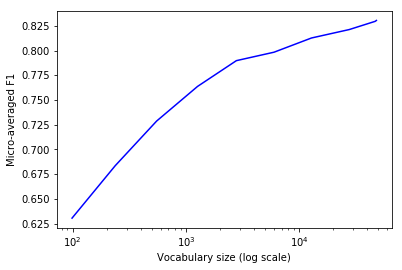

In [11]:
# to show to entire range of possible F1 values
F1s, vocab_norms = [], []
for k in tqdm(np.logspace(start=1, stop=6, base=10, num=14)):
    # evaluate model using these top k features
    norm_vocab, score = evaluation(train_data, test_data, top_features, k=int(k), disp=False)
    F1s.append(score)
    vocab_norms.append(norm_vocab)   
    
    
# plot figure
plt.plot(vocab_norms, F1s, 'b-')
plt.xscale('log')
plt.xlabel('Vocabulary size (log scale)')
plt.ylabel('Micro-averaged F1')
plt.show()

**Evaluation**:<br>
The task is to evaluate the effectiveness of our classifier with three levels of feature selection (by means of mutual information) applied; 10 features per class, 100 features per class and no feature selection. Effectiveness is measured by precision, recall and $F_1$ for each class separately and micro-averaged over classes (by summing tp, fn and fp counts over classes).<br>
To this end we have implemented the ``evaluation`` function which takes care of the following:<br>
* First, before calling the ``evaluation`` function, the top features are determined for each class using ``get_best_n_words()``. As a result, for each class an ordered list of features is returned w.r.t. the information scores of the features.
* These features are passed on to the ``evaluation`` function in which the training set data gets pre-processed using the top $k$ of these features per class. In it, all terms that are not features (i.e. not part of the $\approx10*k$ top features) are removed from the local copy of the training data. Note the additional ``disp`` parameter, which determines whether the output is returned (for the plot) or printed on screen.
* A new model is trained on the reduced training data.
* The estimated model is used to predict classes to testing set documents to obtain a vector of classifications for the testing set.
* This vector is compared to the ground truth and for each class precision, recall and $F_1$ is calculated.
* Finally, the true positives, false negatives and false positives are aggregated to estimate a micro-averaged $F_1$ score for the entire classifier over all classes. Validity of this method has been verified using the sklearn's ``f1_score`` function (although not used for the actual computation).

This is repeated for all three levels of feature selection. 

There are multiple ways to evaluate the Naive Bayes model with feature selection, but by implementing this pipeline we have opted for the "filter method" approach that consists of:  1) Finding the set of all features (i.e. the vocabulary), 2) selecting the best subset using mutual information, 3) training the algorithm and 4) evaluating using some evaluation metric (in our case, precision, recall and $F_1$).

**Observations**: <br>
As you can see, feature selection does not work well for our purpose to increase accuracy / micro-averaged $F_1$ (see figure in the previous cell). As from our experiments, not using feature selecting increases the accuracy of our classifier. However, we can reduce the amount of features to some value such as $k=40.000$ features to reduce model complexity and reduce memory usage (However this does decrease prediction accuracy a bit).

The figure above does not look like figure 13.8 from MRS. In the figurem microaveraged $F_1$ increases with the vocabulary size. This is usually the case when reliable features are used among unreliable features (as in a mixed or unordered set of features). We verified that this is not the case with the use of our feature selection method (features that are used with a low value of $k$ are in fact very representitative of a single class; these features have high MI scores).

**Additional notes on feature selection and test set**:<br>
In the examples in the previous cells we evaluate whether feature selection increases the accuracy of our classifier. However, in a normal setting, we would not test this on the test set, but a development set instead with more unseen data. We are not actually using the classifier in the real word and we are therefore not selecting any feature selection as part of the model itself (which should be tested together, where the feature selection level was optimized using the development set). Therefore, we proceed to evaluate feature selection the model on the test set anyway, eventhough we should in practice really be doing this on a development set if we were using feature selection as part of our model.

---
# Question 7:
## You have done the complete implementation by yourself. Congratulations! You can also use `scikit-learn` routines for all of this work. Do that. So follow [this text classification tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) and implement the same steps but now with your kamervragen dataset. Also use [mutual information feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) to select the K-best features, and compare the results as before. 

In [10]:
# converts the dict representation to list data and target format
def dict_to_list(dct, class_names):
    data, targets = [], []
    for c, docs in dct.items():
        # if class does not yet exist, assign integer value to class
        if c not in class_names:
            class_names[c] = len(class_names)
        for doc_name, doc in docs.items():
            targets.append(class_names[c])
            data.append(' '.join(doc))
    return data, targets, class_names

# convert dictionary format to list format preferred by sklearn
train_data2, train_targets, class_names = dict_to_list(train_data, dict())
test_data2, test_targets, _ = dict_to_list(test_data, class_names)

# convert documents to CountVectors (Note the parameters in CountVectorizer
# we require min_df to ensure that the mutual information can be computed fairly quickly)
count_vect = CountVectorizer(min_df=10)
train_counts = count_vect.fit_transform(train_data2)
test_counts = count_vect.transform(test_data2)

print('\033[1mFeature selection microaveraged F1 using sklearn:\033[0m')
for k in [10, 100, 500, 1000, 10000, 'all']:
    
    # select k best features using SelectKBest and mutual information
    selector = SelectKBest(mutual_info_classif, k=k)
    train_counts2 = selector.fit_transform(train_counts, train_targets)
    test_counts2 = selector.transform(test_counts)

    # train multinomial Naive Bayes classifier
    clf = MultinomialNB().fit(train_counts2, train_targets)

    # testing on test set
    preds = clf.predict(test_counts2)
    print('k = {}:'.format(k), f1_score(test_targets, preds, average='micro'))

Feature selection microaveraged F1 using sklearn:
k = 10: 0.4049438202247191
k = 100: 0.6238202247191011
k = 500: 0.7215730337078652
k = 1000: 0.7498876404494382
k = 10000: 0.806067415730337
k = all: 0.8168539325842696


In the code cell above we have recreated our own implementation of Multinomial Naive Bayes using build-in models from ``scikit-learn``.  It implements the following steps:
* Convert the training and testing sets from dictionary format to the format used by sklearn. This is simply a list of strings as the data vector and a list of class IDs for the target:
```
*_data = [string1, string2, ...]
*_target = [0, 1, 3, ...], where the integer IDs correspond to class names.
```
The ``class_names`` dictionary created during training set conversion and containing the mapping from class name to integer ID is passed on to the conversion for the testing set to ensure that both training and testing sets use the same class IDs for the same classes.
* The converted ``train_data`` and ``test_data`` are converted to sklearn's ``CountVectors``. This model is fitted on the training set and it transforms both tests. We found it to be crucial to use the min_df parameter to ignore features with a low collection frequency. This is because we would create enormous CountVector representations in which all class-feature pairs have to be evaluated during feature selection. This is not practical. Therefore we remove infrequent features beforehand which speeds up the process by a lot.
* For multiple values of $k$ and 'all' (i.e. no feature selection), the best features are selected using the ``SelectKBest`` function and the ``mutual_info_classif`` metric. 
* A Naive Bayes model is fit to the CountVectors (in which the $k$ best features are selected). 
* We predict for each document in the (reduced) test set to what class it belongs using the ``predict`` method which results in a large vector of classifications.
* This vector is compaed to the true labels using the $F_1$ score built into sklearn.

This is again done for multiple levels of feature selection. Note that the values 100 and 1000 and are equivalent with 10 and 100 respectively in our own implementation. The reason for this is because the feature selector will select exactly $k$ features, which on average is $\frac{k}{10}$ features for each class. In the previous code that we have implemented ourselves, we used 10 and 100 for <i>each class</i>, therefore we have to scale $k$ by 10 in the sklearn implementation to obtain a nearly identical amount of features (vocabulary size). This allows us to compare the results in the next section.

Also, although we have followed the tutorial fairly closely, we have not implemented it using the additional ``TfidfTransformer``. This is because our own implementation does not use tf-idf feature vectors. In our testing, using tf-idf features decreases performance across the entire range of feature selection levels.


---
# Question 8:
## Reflect and report briefly about your choices in this process and about the obtained results. Also reflect on the differences between the scikit learn approach and the "own implementation approach".

The process from (nearly) raw data to the final classifier and evaluation has the following stages (as highlighted by the questions). We will discuss each stage separately:

**Pre-processing and text normalization:**<br>
We found that there was quite some variety of wordforms w.r.t. some lemma (e.g."Financien", "financien", "financiën" and "Financiën"). Therefore, we have opted for a fairly agressive form of normalization by converting the text to lowercase, replacing all unicode characters with most similar ASCII character, word segmentation by which punctuation is separated from wordforms (e.g. "financiën." to "financiën" and "."), etc. We found that we could reduce the vocabulary significantly which has the added bonus that we have to estimate less parameters for our Naive Bayes model.
Additionally, applying the normalization described in question 1 to the classes/ministries reduces the amount of classes significantly and hence increases the amount of data to train our model on per class. However, we have been careful with normalization on the document text to ensure that useful features are preserved (such as numbers and abbreviations).

**Classifier design:**<br>
For the classifier we used a dictionary representation we were used to from our earlier assignment of the inverted index and it made the implementation efficient. The place where our conditional probabilities are stored could be seen as an index; a dict with for every term of the vocabulary a dict with probabilites for every class. Furthermore, the prior probabilities are also calculated and stored in a dict. These two dicts represent the model which are used for the Naive Bayes classifier. To classify, the given Naive Bayes formula (see question 2) is used. From the results we saw a pretty good working algorithm in terms of both efficiency and accuracy. 


**Calculating Mutual Information:**<br>
Our implementation of the mutual information, unlike the classifiers,  makes use of  dataframes. This is partly due to the fact that it different people have implemented both questions but also because of the fact that it made the calculation of the different N values: $N_{10},N_{11},  etc.$ relatively easy.  We have  choosen to make the outer for-loop iterate over the classes and the inner for-loop over the terms because retrieving the documents that belong to the class and the complement is a relatively expensive operation. We therefore wanted to minimize the amount of times this operation had to be executed.

**Evaluation of Classifier and Feature Selection:**<br>
The resulting 10 best features of our feature selection make a lot of sense as they are all closely related to the class or "ministerie" they are associated with. Often the list of 10 contains atleast one word which occurs in the class name, the feature "justitie" for example is prominent in the class "justitie" while it does not occur in any of the other top 10's. This is an indication that our mutual information implementation works as it should.

We designed the algorithm in line with the "filter method" for evaluating feature selection. In it, a model is trained on the training set in which unreliable or noisy features are removed. Obviously, other methods are possible (such as training on the regular training set and filtering the terms in the to-be classified documents), but this is the most custom manner of using mutual information for feature selection. 

**Observations:**<br>
As shown in question 7, in our implementation the feature selection does not perform as well as we expected. Accuracy (or equivalently micro-averaged $F_1$) increases with the vocabulary size. Micro-averaged $F_1$ decreases when the vocabulary is reduced in both our implementation and the sci-kit implementation.

**Differences between sci-kit implementations and our own implementation:**<br>
The underlying principles of the sklearn implementation of Multinomial Naive Bayes seems to be very similar to our own implementation (considering that we have intentionally not implemented the tf-idf version of the classifier).  One superficial difference is the data structure that is used as input to the training routine (in this case ``fit_transform``). The estimation of mutual information is performed using a non-parametric k-nearest neighbours approach unlike our approach using the formula specified in question 4.